# A tour of classification metrics

Author: [Thomas Moreau](https://tommoral.github.io/) and [Alexandre Gramfort](http://alexandre.gramfort.net)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Binary classification

In binary classification we have two classes $\{0, 1\}$, often called Positive and Negative and we try to predict the class $y_i$ for each sample $X_i$. A simple example would be to try to predict whether a dog is present or not in a given image. In this case, the Positive class is the class of all photos of dogs and the Negative class includes all the other photos. The goal of the classifier is to predict, for each photo, if it is Positive (P) or Negative (N): is there a dog in the photo?

An interesting way to visualize the performances of the classifier is to look at the confusion matrix of the classifier.

<img src="images/confusion_dog.png" width="450"/>

This confusion matrix displays all the information about the performance of our classifier.
We can see for each class whether or not it is well classified. In this example, 2 photos with dogs were classified as Negative (no dog!), and 1 photo without a dog was classified as Positive (dog!).

- When a Positive sample is falsely classified as Negative, we call this a False Negative (FN). 
- When a Negative sample is falsely classified as a Positive, it is called a False Positive (FP).

Classification metrics are commonly derived from the confusion matrix. We now present some of these metrics.

See also https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

In [2]:
# Create a classification problem and train a classifier to solve it.
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data, target = make_classification(
    n_samples=400, n_features=20, n_classes=2,
    weights=[.7, .3], random_state=42, flip_y=.2,
)

X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0
)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.82


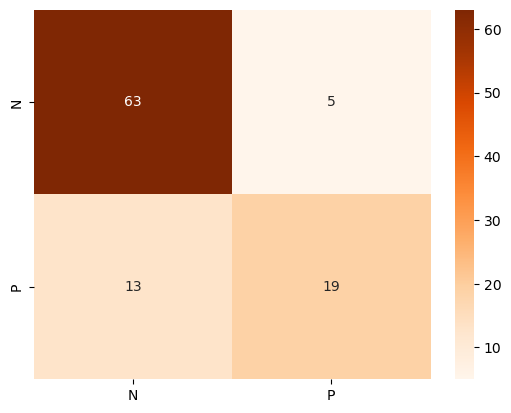

In [3]:
# Display the confusion matrix for our classifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['N', 'P'],
    index=['N', 'P']
)
sns.heatmap(cm_df, annot=True,
            cmap='Oranges',)
_ = plt.ylim(2, 0)

If you have recent scikit-learn you can also use the [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) API:

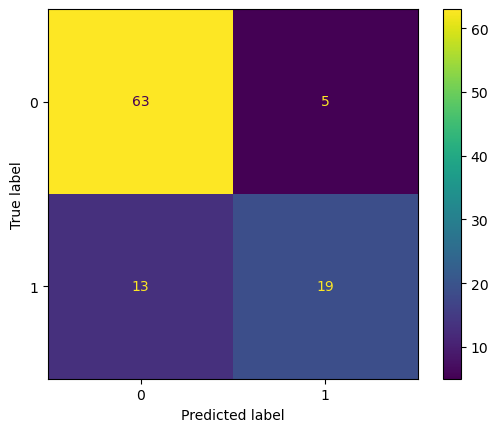

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Accuracy/ Zero-One Loss

The idea of the accuracy is to measure how well your model predicted the class of the samples. This corresponds to the empirical risk of the model
$$
    \text{Accuracy} = \frac{1}{N}\sum_{i=1}^N 1\{\widehat y_i = y_i\} \enspace,
    \quad \text{Error} = 1 - \text{Accuracy} = \frac{1}{N}\sum_{i=1}^N 1\{\widehat y_i \neq y_i\} \enspace.
$$
It corresponds to the probability of correct classification using the classifier.

This is the most common metric used to evaluate a classification task.  

Given a confusion matrix $C$, the accuracy is computed as $ \dfrac{\text{Tr}(C)}{N} $

In [5]:
print("Accuracy: ", (y_pred == y_test).mean())
print("Score scikit-learn: ", clf.score(X_test, y_test))

Accuracy:  0.82
Score scikit-learn:  0.82


Note that accuracy will not be 0.5 at chance level for any classification problem. It will only be the case if the dataset is balanced. The scikit-learn [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) is good way to evaluate what is chance level for your problem.

In [8]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train, y_train)
print("Score scikit-learn: ", clf.score(X_test, y_test))

Score scikit-learn:  0.68


To take into account the class imbalance you can use the **balanced accuracy** as score.

The balanced accuracy takes into account the proportions of each class.

See https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score for the definition.

In [7]:
from sklearn.metrics import balanced_accuracy_score

print("Score scikit-learn: ", balanced_accuracy_score(y_test, clf.predict(X_test)))

Score scikit-learn:  0.5


### Precision and Recall

The precision and recall are both defined relatively to a chosen positive class.

- **Precision** is the fraction of positive instances among the instances predicted as positive 
- **Recall** is the fraction of the total amount of positive instances that were actually retrieved.

These two metrics are computed as
$$
        \text{Precision} = \frac{TP}{TP+FP}
        \quad \text{and} \quad
        \text{Recall} = \frac{TP}{TP+FN} \enspace.
$$

<img src="images/precision_recall.png" width="750"/>

While recall is also known as `sensitivity`, the `specificity` (a.k.a. true negative rate) is defined as:

$$
        \text{Specificity} = \frac{TN}{TN+FP} \enspace.
$$

<img src="images/covid.png" width="700">

Taking our example back, with positive class `1`, we get

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
print(f"Precision : {precision}")
print(f"Recall : {recall}")

These two metrics better describe the performance of the classifier, which tends to predict a majority of positive value. We can see in this example that the recall -- *i.e.* the recovery rate of the positive class -- is only at 60% while we have a precision of 80%. This means that our model is conservative. the few examples classified as positive are well chosen but to reach this good precision, we drop a lot of the other positive samples.

It is usefull to note that **these two metrics are complementary**. They result from a tradeoff between:
- Predictions are trustworthy (when the model predicts positive, it is confident that it will be true) 
- You don't reject too many samples (when a positive sample is presented to the model, it will be predicted as positive). 

To illustrate this concept, let's consider the limit case:

* If a model always predicts samples as negative, it has a precision of 1 but it has a recall of 0 as it never finds the positive samples.
* Inversely, if a model always predicts samples as positive, it has a recall of 1 (all the positive samples are classified as positive) but it as a poor precision as all negative samples are also classified as positive. 


### F1 score

The inherent issue with precision and recall is that you can't optimize for both at the same time. As they result of a tradeoff, when you maximize one of the metric, the other will automatically decrease. A convenient way to balance these two metrics is to use the F1-score. This metric combines both the precision and recall and tries to balance both. This score is computed as the harmonic mean of the precision $P$ and recall $R$ *i.e.*

$$
    \text{F1} = 2 * \frac{P \times R}{P + R}\enspace.
$$
The use of a harmonic mean permits to give more importance to low scores. Thus, a precision and recall of $(0.8, 0.8)$ will have a larger F1-score compared to $(1, 0.6)$, unlike with arithmetic mean.

In [ ]:
from sklearn.metrics import f1_score
print(f"F1-score : {f1_score(y_test, y_pred, pos_label=1)}")

This metric is often used for model selection, to ensure a **good balance between the precision and recall** in the final model.

The classic F1-score gives the same weight to the precision and the recall. But it is also possible to **change balance between precision and recall** by using a modified f1-score for a given value $\beta > 0$
$$
    \text{F1-score}_\beta =  (1 + \beta^2) * \frac{P . R}{\beta^2 P + R} \enspace .
$$
Setting $\beta = 2$ gives twice as much importance to the recall as to the precision while $\beta = 1/2$ will do the opposite. You can use the slider below to see how the F1-score varies with $\beta$, as a function of precision and recall.

In [ ]:
import numpy as np
t = np.linspace(1e-16, 1, 101)
P, R = np.meshgrid(t, t)

def plot_f1(beta):
    F1 = (1 + beta*beta) * (P*R) / (beta*beta*P+R)
    plt.contourf(P, R, F1, 25, cmap='viridis')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.clim([0, 1])
    plt.colorbar()

from ipywidgets import interact, widgets

_ = interact(plot_f1, beta=widgets.FloatLogSlider(
    value=1, min=-1, max=1, step=0.05,
    description='$\\beta$')
)

### ROC / AUC

We take back our `LogisticRegression` classifier:

In [9]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

Another way to look at the results from our classifier is the ROC curve (Receiver Operating Characteristic). 

Quoting Wikipedia :

> A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as **its discrimination threshold is varied**. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

In other words, if the classifier provides a decision function that can be thresholded to control false positives versus false negatives, the ROC curve summarises the different tradeoffs that can be achieved by varying this threshold.

The computation of this curve requires the true labels $y_i$ and the target scores $p_i$, which can either be probability estimates of the positive class, confidence values, or binary decisions. The curve represents the True Positive Rate as a function of the False Positive Rate when varying the decision threshold. In other words, for a decision threshold $\alpha \in [0, 1]$, the ROC curve compute the FPR and TPR of a classifier such that $f(X_i) = 1\{p_i > \alpha)$. A perfect classifier, for which there exist a value $\alpha$ such that all negative samples have a score lower than $\alpha$ and all positive samples have a score higher, would have a ROC curve which would be a step function. A random classifier would have a [diagonal ROC](https://datascience.stackexchange.com/a/31877) curve.

With our example, the ROC curve gives:

[       inf 0.96903949 0.90041142 0.87039562 0.67229219 0.65309708
 0.64166256 0.6216824  0.59499651 0.44167374 0.37848511 0.26738728
 0.26672434 0.21385302 0.20759259 0.20280215 0.19411036 0.18831308
 0.18427044 0.16940238 0.16489778 0.12619606 0.12553237 0.07790543
 0.07715405 0.06361616 0.05362677 0.01209557 0.00940685]
[0.      0.03125 0.15625 0.15625 0.40625 0.40625 0.53125 0.53125 0.59375
 0.59375 0.6875  0.6875  0.71875 0.71875 0.75    0.75    0.78125 0.78125
 0.8125  0.8125  0.84375 0.84375 0.875   0.875   0.90625 0.90625 0.96875
 0.96875 1.     ]


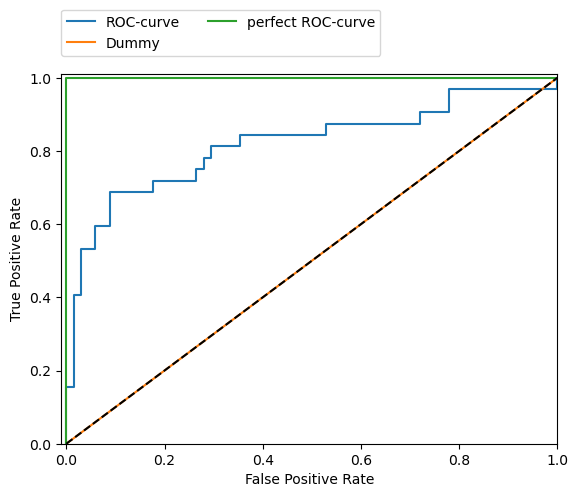

In [10]:
from sklearn.metrics import roc_curve

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

clfd = DummyClassifier()
clfd.fit(X_train, y_train)

p_test = clf.predict_proba(X_test)[:, 1]
p_testd = clfd.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
plt.plot(fpr, tpr, label='ROC-curve')

fprd, tprd, thresholdsd = roc_curve(y_test, clfd.predict_proba(X_test)[:, 1], pos_label=1)
plt.plot(fprd, tprd, label='Dummy')

plt.plot([0, 0, 1], [0, 1, 1], label='perfect ROC-curve')
plt.plot(range(0, 2), 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(0, 1.05, 1., .3),
           loc=3, borderaxespad=0);

print(thresholds)
print(tpr)

While this curve is convenient to visualize the performance of the classifier, it is usually summarized by the AUC metric which is the area under the ROC curve. This metric scales in $[0, 1]$.

In [ ]:
from sklearn.metrics import roc_auc_score

p_test = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, p_test, pos_label=1)
plt.plot(fpr, tpr, label='ROC-curve')
plt.plot(range(0, 2), 'k--')
plt.fill_between(fpr, tpr, hatch='\\', alpha=0.3, label='AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(0, 1.05, 1., .3),
           loc=3, borderaxespad=0)

auc = roc_auc_score(y_test, p_test)
print(f"AUC : {auc}")

Note that you can do similar curves with precision and recall:

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

p_test = clf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(
    y_test, clf.predict_proba(X_test)[:, 1], pos_label=1
)
plt.plot(recall, precision, label='PR-curve')
plt.plot([0, 1, 1], [1, 1, 0], label='perfect PR-curve')
plt.plot([0, 1], [1, 0], 'k--')
plt.fill_between(recall, precision, hatch='\\', alpha=0.3, label='AUC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(0, 1.05, 1., .3),
           loc=3, borderaxespad=0)

pr_auc = auc(recall, precision)
print(f"PR-AUC : {pr_auc}")

## Multi-class metrics

Some metrics are essentially defined for binary classification tasks (e.g. F1-score, AUC). In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. There are several ways to average binary metric calculations across the set of classes, each of which may be useful in some scenario. Where available, you should select among these using the average parameter.

 * **Macro-average**: simply calculates the mean of the binary metrics, giving equal weight to each class. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class.
 * **Weighted-average**: accounts for class imbalance by computing the average of binary metrics in which each class’s score is weighted by its presence in the true data sample.
 * **Micro-average**: gives each sample-class pair an equal contribution to the overall metric (except as a result of sample-weight). Rather than summing the metric per class, this sums the dividends and divisors that make up the per-class metrics to calculate an overall quotient. Micro-averaging may be preferred in multilabel settings, including multiclass classification where a majority class is to be ignored.

We will see in the second part of the class how imbalanced classes can be handled efficiently.

In [ ]:
# [PLCR]

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

w = np.array([.7, .1, .2])
data, target = make_classification(
    n_samples=600, n_features=20, n_classes=3, n_clusters_per_class=1,
    weights=w, random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0
)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f1_score(y_test, y_pred, average=None))
print(np.mean(f1_score(y_test, y_pred, average=None)))
print(f1_score(y_test, y_pred, average='macro'))
print(np.sum(np.multiply(f1_score(y_test, y_pred, average=None), w)))
print(f1_score(y_test, y_pred, average='weighted'))